# Split long words and correct spelling on small ones (<=15 characters)

In [1]:
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
from data_preparation import loadData, SentenceSplitter

## Load text words

In [2]:
_, _, allData, _ = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


In [3]:
data = SentenceSplitter("comment_text").transform(allData)

Splitting sentences...


In [4]:
textWords = set([word for sentence in data for word in sentence])

## Load small embedding

In [6]:
embedding = KeyedVectors.load("../../state/external-models/glove.6B/saved-2300.bin", mmap="r")

In [7]:
embeddingWords = embedding.vocab.keys()

In [8]:
len(embeddingWords)

2196016

## Missing words count and distribution

In [9]:
missingWords = textWords - embeddingWords
print("Missing {} words out of total {} words. This is {}% of the words!".format(
    len(missingWords), 
    len(textWords),
    int(len(missingWords) / len(textWords) * 100)))

Missing 123736 words out of total 223966 words. This is 55% of the words!


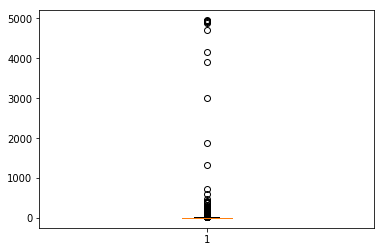

In [10]:
import matplotlib.pyplot as plt

plt.boxplot([len(word) for word in missingWords])

plt.show()

In [11]:
len([word for word in missingWords if len(word) >= 1000])

13

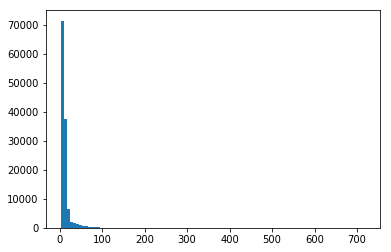

In [12]:
plt.hist([len(word) for word in missingWords if len(word) < 1000], bins=100)

plt.show()

In [13]:
len([word for word in missingWords if len(word) >= 100])

317

In [14]:
# This is how large an 100 char word is!!
len("sgfdgfdglgdsgfdggfdgghdggsdggfdhgfdfdggfdghgsafldsfdsfdsfdsfdsfdsfdsffdssafsFEGFFDGFDSGFDgfdgfdsfdsf")

100

In [15]:
# This is a 24 char word
len("Pozessorgeschwindichkeit")

24

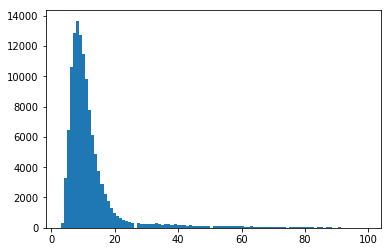

In [16]:
plt.hist([len(word) for word in missingWords if len(word) < 100], bins=100)

plt.show()

In [17]:
len([len(word) for word in missingWords if len(word) < 20]) / len(missingWords)

0.9044013060063361

In [18]:
len([len(word) for word in embeddingWords if len(word) < 20]) / len(embeddingWords)

0.9899640986222322

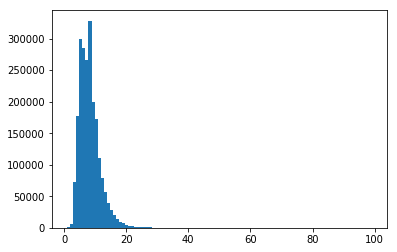

In [20]:
# Histogram of 'normal' words
plt.hist([len(word) for word in embeddingWords if len(word) < 100], bins=100)

plt.show()

In [21]:
list(missingWords)[0:30]

['canceladas',
 'retourism',
 'malignacy',
 'fischerqueen',
 'fggot',
 'talkcoldfusionnewarticle',
 'floatright',
 'tighina',
 'badvista',
 'creationalex',
 'confifting',
 'meaningsuch',
 'getligaen',
 'owellen',
 'antimugabe',
 'httppersowanadoofrleuven',
 'sameneguy',
 'cpurse',
 'exmemberscritics',
 'cydevil',
 'editconservationist',
 'machidas',
 'gorts',
 'wwwhoyhoycom',
 'hawash',
 'volunteermareks',
 'printprint',
 'neuralneutral',
 'lightankh',
 'eljohnson']

## Word distance

In [22]:
import editdistance

In [23]:
def closestEditWord(inputWord, dictionaries):
    result = None
    for word in dictionaries[len(inputWord)]:
        if editdistance.eval(word, inputWord) <= 1:
            result = [word]
            break
    return result

In [24]:
cutSize = 15

smallWords = [word for word in missingWords if len(word) <= cutSize]
largeWords = [word for word in missingWords if len(word) > cutSize]

In [25]:
smallEmbeddingWords = [word for word in embeddingWords if len(word) <= 17]

In [26]:
dicts = {i: list(filter(lambda w: (len(w) <= i + 1) and (len(w) >= i - 1), smallEmbeddingWords)) for i in range(2, 16) }

In [75]:
%%time
from multiprocessing import Pool

def closestWord(indexedWord):
    index, word = indexedWord
    if index % 1000 == 0:
        print("{}/{} words...".format(index, len(smallWords)))
        
    return (word, closestEditWord(word, dicts))

with Pool(processes=4) as pool:
    closestWords = pool.map(closestWord, list(enumerate(smallWords)))

0/103718 words...
10/103718 words...
20/103718 words...
30/103718 words...
50/103718 words...
40/103718 words...
60/103718 words...
70/103718 words...
80/103718 words...
90/103718 words...
CPU times: user 40 ms, sys: 172 ms, total: 212 ms
Wall time: 28.4 s


## Split words without space

In [77]:
from math import log
wordcost = dict((k, log((i+1)*log(len(embeddingWords)))) for i,k in enumerate(embeddingWords))
maxword = max(len(x) for x in embeddingWords)

def inferSpaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return list(reversed(out))

In [90]:
%%time
wordsToSplit = [word[0] for word in closestWords if word[1] == None] + largeWords
splitWords = [(word, inferSpaces(word)) for word in wordsToSplit]

CPU times: user 1min 13s, sys: 12 ms, total: 1min 13s
Wall time: 1min 13s


In [92]:
%%time
missingWordsResolutionDictionary = dict(splitWords + [word for word in closestWords if word[1] != None])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.16 ms


In [149]:
import pickle

def saveObject(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f, 0)

In [150]:
saveObject(large, "./missingWordsResolution.plk")

In [151]:
def loadObject(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [152]:
sanityCheck = loadObject("./missingWordsResolution.plk")